## Opening up multiple ROOT files with extracted calorimeter features. These are mixed electrons and gammas at different energies.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np

/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
dataDir = "../Data/h5/"
dataFiles = ["EleEscan_8_95_flatNtuple.h5", "EleEscan_1_538_flatNtuple.h5", "GammaEscan_1_538_flatNtuple.h5", "GammaEscan_8_95_flatNtuple.h5"]

In [3]:
dataFile = []
for i in range(len(dataFiles)):
    dataFile.append(h5py.File(dataDir + dataFiles[i], "r"))
    #dataFile['flatNtuple'].attrs.items()

## Combining samples, and explicitly labelling the electrons as class '1' and photons as class '0'.

In [7]:
data = {}
features = ['gunpx', 'gunpy', 'gunpz', 'm', 'gunE', 'pdgID', 'nhcalhits', 'necalhits', 'hcaltote', 'ecaltote']
for count, feature in enumerate(features):
    newFeature = []
    for fileN in range(len(dataFile)):
        newFeature += [event[count] for event in dataFile[fileN]['flatNtuple']]
    data[feature] = newFeature;

In [21]:
y = [int(abs(x) == 11) for x in data['pdgID']];
X = np.column_stack((data['nhcalhits'], data['necalhits'], data['hcaltote'], data['ecaltote']))

In [23]:
from sklearn.cross_validation import train_test_split

X_dev, X_eval, y_dev, y_eval = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33, random_state=492)

/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=3)
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)

bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=800, random_state=None)

In [29]:
y_predicted = bdt.predict(X_test)
#target_names = ['class 0', 'class 1', 'class 2']
target_names = ['photon', 'electron']
print (classification_report(y_test, y_predicted, target_names=target_names))
print ("Area under ROC curve: %.4f"%(roc_auc_score(y_test, bdt.decision_function(X_test))))

             precision    recall  f1-score   support

     photon       0.76      0.76      0.76        46
   electron       0.74      0.74      0.74        43

avg / total       0.75      0.75      0.75        89

Area under ROC curve: 0.8016


Precision (P) is defined as the number of true positives (T_p) over the number of true positives plus the number of false positives (F_p).  
P = \frac{T_p}{T_p+F_p}  
Recall (R) is defined as the number of true positives (T_p) over the number of true positives plus the number of false negatives (F_n).  
R = \frac{T_p}{T_p + F_n}

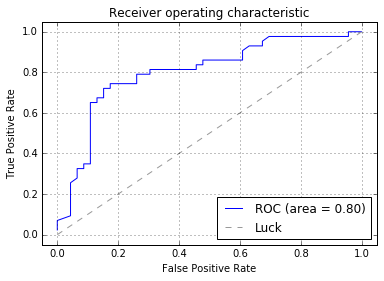

In [30]:
from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(X_test)
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.resha

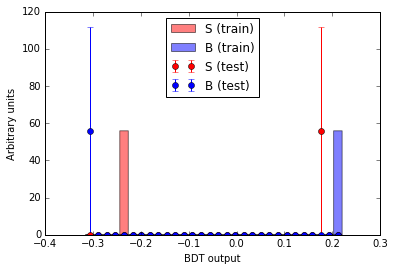

In [31]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0], color='r', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', normed=True, label='S (train)')
    plt.hist(decisions[1], color='b', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', normed=True, label='B (train)')

    hist, bins = np.histogram(decisions[2], bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3], bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(bdt, X_train, y_train, X_test, y_test)